# Đồ án cuối kỳ
# Môn: Xử lý dữ liệu lớn
# Học kỳ 1 - Năm học 2022-2023
# Giảng viên: Th.S. Nguyễn Thành An

# Cài đặt PySpark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# !cp drive/MyDrive/tmp/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

# Yêu cầu

## Spark Context

In [3]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext("local", 'CK')
sqlc = SQLContext(sc)

## Câu 1: Giảm số chiều với SVD

In [7]:
import numpy as np
data = sc.textFile('/content/oxford_pet3_train.csv')

data_reshape = data.map(lambda x: x.split(','))\
              .map(lambda x: (x[0], x[1], np.array(x[2:], dtype=int).reshape(128,128,3)))


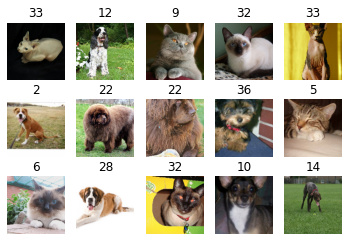

In [21]:
import matplotlib.pyplot as plt
for i, it in enumerate(data_reshape.take(15)):
  plt.subplot(3,5,i+1)
  plt.axis('off')
  img = it[2]
  plt.imshow(img)
  plt.title(it[1])
plt.show()

In [ ]:
# from pyspark.mllib.linalg import Vectors
# from pyspark.mllib.linalg.distributed import RowMatrix

# a = data.map(lambda x: x[2:])
# mat = RowMatrix(a)

# svd = mat.computeSVD(50, computeU=True)
# # U = svd.U       
# # s = svd.s       
# # V = svd.V 

## Câu 2: Khuyến nghị sản phẩm với Collaborative Filtering

## Câu 3: Dự đoán giá chứng khoán

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression

In [ ]:
data = sqlc.read.csv("/content/sample_data/stockHVN2022.csv", header=True)

In [ ]:
trainingset = data.rdd.filter(lambda x: int(x[0].split('/')[1])<9).toDF()
testingset = data.rdd.filter(lambda x: int(x[0].split('/')[1])>=9).toDF()
testingset.show()

+----------+-----+
|      Ngay|  HVN|
+----------+-----+
|18/11/2022| 9.30|
|17/11/2022| 9.42|
|16/11/2022| 9.21|
|15/11/2022| 8.61|
|14/11/2022| 9.25|
|11/11/2022| 9.90|
|10/11/2022| 9.76|
|09/11/2022|10.40|
|08/11/2022|10.25|
|07/11/2022|10.10|
|04/11/2022|10.70|
|03/11/2022|10.85|
|02/11/2022|10.90|
|01/11/2022|10.90|
|31/10/2022|10.80|
|28/10/2022|10.75|
|27/10/2022|10.85|
|26/10/2022|10.55|
|25/10/2022|10.55|
|24/10/2022|10.55|
+----------+-----+
only showing top 20 rows



In [ ]:
trainingset = trainingset.withColumn("HVN", trainingset['HVN'].cast("double"))
testingset = testingset.withColumn("HVN", testingset['HVN'].cast("double"))

In [ ]:
from pyspark.sql.functions import col
timestep = 5
train = trainingset.collect()
tmp = []
for i in range(timestep, len(train)):
  fivedays = []
  k = i
  for j in range(timestep):
    fivedays.append(train[k-timestep][1])
    k+=1
  tmp.append([fivedays, train[i][1]])
train = sqlc.createDataFrame(tmp).select(col('_1').alias('features'), col('_2').alias('target'))

test = testingset.collect()
tmp = []
for i in range(timestep, len(test)):
  fivedays = []
  k = i
  for j in range(timestep):
    fivedays.append(test[k-timestep][1])
    k+=1
  tmp.append([fivedays, test[i][1]])
test = sqlc.createDataFrame(tmp).select(col('_1').alias('features'), col('_2').alias('target'))

In [ ]:
def vector(x):
    return Vectors.dense(x)

In [ ]:
test.show()

+--------------------+------+
|            features|target|
+--------------------+------+
|[9.3, 9.42, 9.21,...|   9.9|
|[9.42, 9.21, 8.61...|  9.76|
|[9.21, 8.61, 9.25...|  10.4|
|[8.61, 9.25, 9.9,...| 10.25|
|[9.25, 9.9, 9.76,...|  10.1|
|[9.9, 9.76, 10.4,...|  10.7|
|[9.76, 10.4, 10.2...| 10.85|
|[10.4, 10.25, 10....|  10.9|
|[10.25, 10.1, 10....|  10.9|
|[10.1, 10.7, 10.8...|  10.8|
|[10.7, 10.85, 10....| 10.75|
|[10.85, 10.9, 10....| 10.85|
|[10.9, 10.9, 10.8...| 10.55|
|[10.9, 10.8, 10.7...| 10.55|
|[10.8, 10.75, 10....| 10.55|
|[10.75, 10.85, 10...| 11.15|
|[10.85, 10.55, 10...|  11.7|
|[10.55, 10.55, 10...|  11.8|
|[10.55, 10.55, 11...| 11.65|
|[10.55, 11.15, 11...| 11.45|
+--------------------+------+
only showing top 20 rows



In [ ]:
train = train.rdd.map(lambda x:[vector(x[0]), x[1]]).toDF()
test = test.rdd.map(lambda x:[vector(x[0]), x[1]]).toDF()

In [ ]:
lr = LinearRegression(featuresCol = '_1', labelCol='_2', maxIter=10, regParam=0.3)
model = lr.fit(train)

In [ ]:
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(model.coefficients))
print("Intercept: %s" % str(model.intercept))

Coefficients: [0.08711430503771608,0.13255914356489037,0.1677926616690607,0.22905638949278911,0.3559724249069625]
Intercept: 0.6516651662566745


In [ ]:
# Summarize the model over the training set and print out some metrics
trainingSummary = model.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))

numIterations: 0
objectiveHistory: [0.0]


In [ ]:
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

+--------------------+
|           residuals|
+--------------------+
| 0.20323515504325584|
|-0.38500943639747476|
| -0.3919497814936541|
| -0.3564841538904062|
| -0.3413032129241138|
| -0.2554633439911136|
| 0.15181886992873928|
|-0.01002613045335...|
| 0.13423071164776346|
|-0.02988267019127...|
| 0.20409860599125196|
| -0.4986608839249662|
| -0.3353594474516086|
|-0.08830975680594122|
| -0.8140831251615737|
| -0.6223301012593367|
| -0.5364656291103458|
|-0.40282824794153527|
| -0.7461644364209192|
| -0.9015896083412329|
+--------------------+
only showing top 20 rows

RMSE: 0.592273
r2: 0.976422


## Câu 4: Phân loại đa lớp với pyspark

In [ ]:
from pyspark import SparkContext, StorageLevel
from pyspark.sql import SQLContext, Window, Row, functions as F
from pyspark.sql.functions import udf, row_number, lit, broadcast, col
from pyspark.sql.types import FloatType, ArrayType, FloatType
from pyspark.mllib.linalg import DenseMatrix
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

In [ ]:
# Chuyển ảnh rbg sang gray scale
def grayScale(img):
    reshaped_img = np.array(img).reshape(128, 128, 3)
    gray_image = Image.fromarray(reshaped_img).convert('L')
    return Vectors.dense(np.array(gray_image).ravel())

In [ ]:
train = sqlc.read.csv('oxford_pet3_train.csv', sep=',', inferSchema=True, multiLine=True )
train = train.rdd.map(lambda x: [x[1], grayScale(x[2:])/255]).toDF(["label", "features"])

In [ ]:
test = sqlc.read.csv('oxford_pet3_train.csv', sep=',', inferSchema=True, multiLine=True )
test = test.rdd.map(lambda x: [x[1], grayScale(x[2:])/255]).toDF(["label", "features"])

In [ ]:
train.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|   33|[0.01568627450980...|
|   12|[0.04705882352941...|
|    9|[0.09803921568627...|
|   32|[0.40392156862745...|
|   33|[0.83921568627450...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
res = train.first()
input_length = len(res['features'])
input_length

In [ ]:
layers = [input_length, 128, 37]
mlpc = MultilayerPerceptronClassifier(layers = layers, stepSize = 0.000005, blockSize=1).setLabelCol('label').setFeaturesCol('features')
model = mlpc.fit(train)

In [ ]:
def getAccuracy(dataset, model):
    result = model.transform(dataset)
    predictionAndLabels = result.select("prediction", "label")
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
    acc = evaluator.evaluate(predictionAndLabels)
    return acc, predictionAndLabels
accuracy_train, predictionAndLabels_train = getAccuracy(train, model)
print("Train set accuracy = " + str(accuracy_train))
predictionAndLabels_train.show()

In [ ]:
accuracy_test, predictionAndLabels_test = getAccuracy(test, model)
print("Test set accuracy = " + str(accuracy_test))
predictionAndLabels_test.show()